# Homework 11 - Transfer Learning (Domain Adversarial Training)

> Author: Howard Wang (b08902047@ntu.edu.tw)

If there are any questions, please contact mlta-2023-spring@googlegroups.com

# Readme

In homework 11, you will need to implement Domain Adversarial Training in Transfer Learning. As shown in the bottom left part of the figure.

<img src="https://i.imgur.com/iMVIxCH.png" width="500px">

> 

## Scenario and Why Domain Adversarial Training
Now we have labeled source data and unlabeled target data, where source data might be relavent to the target data. We now want to train a model with source data only and test it on target data.

What problem might occur if we do so? After we have learned Anomaly Detection, we now know that if we test the model with an abnormal data that have never appeared in source data, our trained model is likely to result in poor performance since it is not familiar with the abnormal data.

For example, we have a model that contains Feature Extractor and Classifier:
<img src="https://i.imgur.com/IL0PxCY.png" width="500px">

When the model is trained with source data, the feature extractor 
will extract meaningful features since it is familiar with the distribution of it.It could be seen in the following figure that the blue dots, which is the distribution of source data, has already been clustered into different clusters. Therefore, the Classifier can predict the label based on these clusters.

However, when test on the target data, the Feature Extractor will not be able to extract meaningful features that follow the distribution of the source feature distribution, which result in the classifier learned for the source domain will not be able to apply to the target domain.


## Domain Adversarial Training of Nerural Networks (DaNN)

Based on the above problems, DaNN approaches build mappings between the source (training-time) and the target (test-time) domains, so that the classifier learned for the source domain can also be applied to the target domain, when composed with the learned mapping between domains.

<img src="https://i.imgur.com/vrOE5a6.png" width="500px">

In DaNN, the authors added a Domain Classifier, which is a deep discriminatively-trained classifeir in the training framework to distinguish the data from different domain by the features extracted by the feature extractor. As the training progresses, the approach promotes a domain classifier that discriminates between the source and the target domains and a feature extractor that can extractor features that are discriminative for the main learning task on the source domain and indiscriminate with respect to the shift between the domains. 


The feature extractor are likely to outperform the domain classifier as its input are generated by the feature extractor and that the task of domain classification and label classification are not conflict.

This method leads to the emergence of features that are domain-invariant and on the same feature distribution.

# Data Introduce

Our task contains source data: real photos, and target data: hand-drawn graffiti.

We are going to train the model with the photos and the labels, and try to predict what the labels are for hand-drawn graffiti.

The data could be downloaded [here](https://github.com/redxouls/ml2020spring-hw11-dataset/releases/download/v1.0.0/real_or_drawing.zip). The code below is for data downloading and visualization.

Note that: **The source and target data are all balanced data, you can make use of this information.**

In [ ]:
# Download dataset
!wget "https://github.com/redxouls/ml2020spring-hw11-dataset/releases/download/v1.0.0/real_or_drawing.zip" -O real_or_drawing.zip

# Download from mirrored dataset link
# !wget "https://github.com/redxouls/ml2020spring-hw11-dataset/releases/download/v1.0.1/real_or_drawing.zip" -O real_or_drawing.zip
# !wget "https://github.com/redxouls/ml2020spring-hw11-dataset/releases/download/v1.0.2/real_or_drawing.zip" -O real_or_drawing.zip

# Unzip the files
!unzip real_or_drawing.zip

Streaming output truncated to the last 5000 lines.
  inflating: real_or_drawing/train_data/0/106.bmp  
  inflating: real_or_drawing/train_data/0/107.bmp  
  inflating: real_or_drawing/train_data/0/108.bmp  
  inflating: real_or_drawing/train_data/0/109.bmp  
  inflating: real_or_drawing/train_data/0/11.bmp  
  inflating: real_or_drawing/train_data/0/110.bmp  
  inflating: real_or_drawing/train_data/0/111.bmp  
  inflating: real_or_drawing/train_data/0/112.bmp  
  inflating: real_or_drawing/train_data/0/113.bmp  
  inflating: real_or_drawing/train_data/0/114.bmp  
  inflating: real_or_drawing/train_data/0/115.bmp  
  inflating: real_or_drawing/train_data/0/116.bmp  
  inflating: real_or_drawing/train_data/0/117.bmp  
  inflating: real_or_drawing/train_data/0/118.bmp  
  inflating: real_or_drawing/train_data/0/119.bmp  
  inflating: real_or_drawing/train_data/0/12.bmp  
  inflating: real_or_drawing/train_data/0/120.bmp  
  inflating: real_or_drawing/train_data/0/121.bmp  
  inflating: re

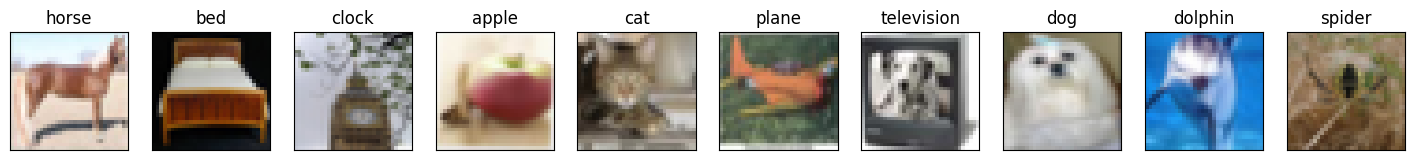

In [ ]:
import matplotlib.pyplot as plt

def no_axis_show(img, title='', cmap=None):
  # imshow, and set the interpolation mode to be "nearest"。
  fig = plt.imshow(img, interpolation='nearest', cmap=cmap)
  # do not show the axes in the images.
  fig.axes.get_xaxis().set_visible(False)
  fig.axes.get_yaxis().set_visible(False)
  plt.title(title)

titles = ['horse', 'bed', 'clock', 'apple', 'cat', 'plane', 'television', 'dog', 'dolphin', 'spider']
plt.figure(figsize=(18, 18))
for i in range(10):
  plt.subplot(1, 10, i+1)
  fig = no_axis_show(plt.imread(f'real_or_drawing/train_data/{i}/{500*i}.bmp'), title=titles[i])

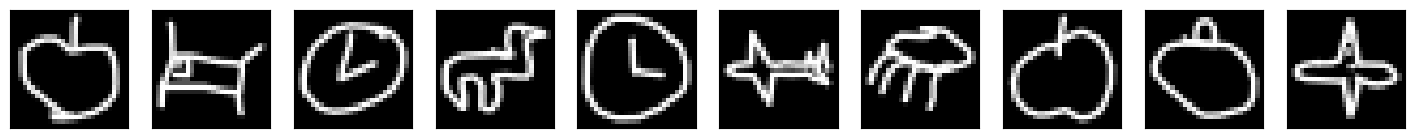

In [ ]:
plt.figure(figsize=(18, 18))
for i in range(10):
  plt.subplot(1, 10, i+1)
  fig = no_axis_show(plt.imread(f'real_or_drawing/test_data/0/' + str(i).rjust(5, '0') + '.bmp'))

# Special Domain Knowledge

When we graffiti, we usually draw the outline only, therefore we can perform edge detection processing on the source data to make it more similar to the target data.


## Canny Edge Detection
The implementation of Canny Edge Detection is as follow.
The algorithm will not be describe thoroughly here.  If you are interested, please refer to the wiki or [here](https://medium.com/@pomelyu5199/canny-edge-detector-%E5%AF%A6%E4%BD%9C-opencv-f7d1a0a57d19).

We only need two parameters to implement Canny Edge Detection with CV2:  `low_threshold` and `high_threshold`.

```cv2.Canny(image, low_threshold, high_threshold)```

Simply put, when the edge value exceeds the high_threshold, we determine it as an edge. If the edge value is only above low_threshold, we will then determine whether it is an edge or not.

Let's implement it on the source data.

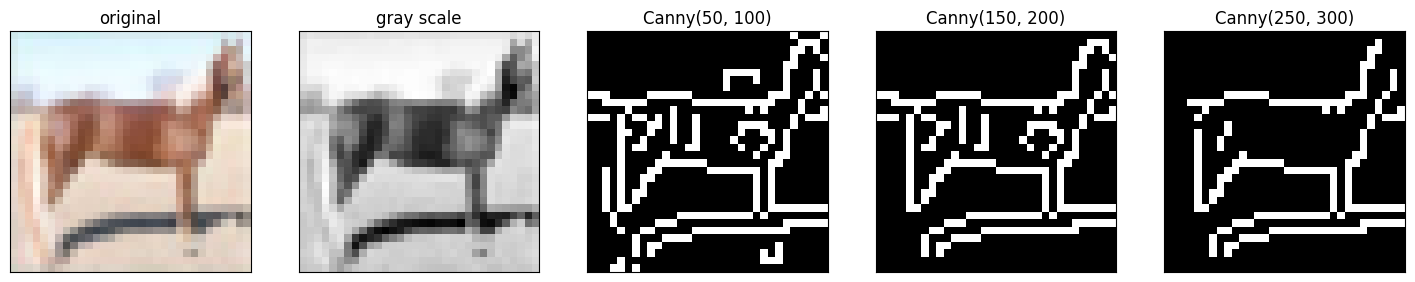

In [ ]:
import cv2
import matplotlib.pyplot as plt
titles = ['horse', 'bed', 'clock', 'apple', 'cat', 'plane', 'television', 'dog', 'dolphin', 'spider']
plt.figure(figsize=(18, 18))

original_img = plt.imread(f'real_or_drawing/train_data/0/0.bmp')
plt.subplot(1, 5, 1)
no_axis_show(original_img, title='original')

gray_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)
plt.subplot(1, 5, 2)
no_axis_show(gray_img, title='gray scale', cmap='gray')

gray_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)
plt.subplot(1, 5, 2)
no_axis_show(gray_img, title='gray scale', cmap='gray')

canny_50100 = cv2.Canny(gray_img, 50, 100)
plt.subplot(1, 5, 3)
no_axis_show(canny_50100, title='Canny(50, 100)', cmap='gray')

canny_150200 = cv2.Canny(gray_img, 150, 200)
plt.subplot(1, 5, 4)
no_axis_show(canny_150200, title='Canny(150, 200)', cmap='gray')

canny_250300 = cv2.Canny(gray_img, 250, 300)
plt.subplot(1, 5, 5)
no_axis_show(canny_250300, title='Canny(250, 300)', cmap='gray')
  

# Data Process
 
 
The data is suitible for `torchvision.ImageFolder`. You can create a dataset with `torchvision.ImageFolder`. Details for image augmentation please refer to the comments in the following codes.

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function
 
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
 

from rich.progress import Progress, TextColumn, BarColumn, TimeElapsedColumn, TimeRemainingColumn, track
import time


source_transform = transforms.Compose([
    # Turn RGB to grayscale. (Bacause Canny do not support RGB images.)
    transforms.Grayscale(),
    # cv2 do not support skimage.Image, so we transform it to np.array, 
    # and then adopt cv2.Canny algorithm.
    transforms.Lambda(lambda x: cv2.Canny(np.array(x), 170, 300)),
    # Transform np.array back to the skimage.Image.
    transforms.ToPILImage(),
    # 50% Horizontal Flip. (For Augmentation)
    transforms.RandomHorizontalFlip(),
    # Rotate +- 15 degrees. (For Augmentation), and filled with zero 
    # if there's empty pixel after rotation.
    transforms.RandomRotation(15, fill=(0,)),
    # Transform to tensor for model inputs.
    transforms.ToTensor(),
])
target_transform = transforms.Compose([
    # Turn RGB to grayscale.
    transforms.Grayscale(),
    # Resize: size of source data is 32x32, thus we need to 
    #  enlarge the size of target data from 28x28 to 32x32。
    transforms.Resize((32, 32)),
    # 50% Horizontal Flip. (For Augmentation)
    transforms.RandomHorizontalFlip(),
    # Rotate +- 15 degrees. (For Augmentation), and filled with zero 
    # if there's empty pixel after rotation.
    transforms.RandomRotation(15, fill=(0,)),
    # Transform to tensor for model inputs.
    transforms.ToTensor(),
])
 
source_dataset = ImageFolder('real_or_drawing/train_data', transform=source_transform)
target_dataset = ImageFolder('real_or_drawing/test_data', transform=target_transform)
 
source_dataloader = DataLoader(source_dataset, batch_size=32, shuffle=True)
target_dataloader = DataLoader(target_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(target_dataset, batch_size=128, shuffle=False)

# Model

Feature Extractor: Classic VGG-like architecture

Label Predictor / Domain Classifier: Linear models.

In [ ]:
class FeatureExtractor(nn.Module):

    def __init__(self):
        super(FeatureExtractor, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
    def forward(self, x):
        x = self.conv(x).squeeze()
        return x

class LabelPredictor(nn.Module):

    def __init__(self):
        super(LabelPredictor, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.ReLU(),

            nn.Linear(512, 10),
        )

    def forward(self, h):
        c = self.layer(h)
        return c

class DomainClassifier(nn.Module):

    def __init__(self):
        super(DomainClassifier, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 1),
        )

    def forward(self, h):
        y = self.layer(h)
        return y

# Pre-processing

Here we use Adam as our optimizor.

In [ ]:
feature_extractor = FeatureExtractor().cuda()
label_predictor = LabelPredictor().cuda()
domain_classifier = DomainClassifier().cuda()

class_criterion = nn.CrossEntropyLoss()
domain_criterion = nn.BCEWithLogitsLoss()

optimizer_F = optim.Adam(feature_extractor.parameters())
optimizer_C = optim.Adam(label_predictor.parameters())
optimizer_D = optim.Adam(domain_classifier.parameters())

# Start Training


## DaNN Implementation

In the original paper, Gradient Reversal Layer is used.
Feature Extractor, Label Predictor, and Domain Classifier are all trained at the same time. In this code, we train Domain Classifier first, and then train our Feature Extractor (same concept as Generator and Discriminator training process in GAN).

## Reminder
* Lambda, which controls the domain adversarial loss, is adaptive in the original paper. You can refer to [the original work](https://arxiv.org/pdf/1505.07818.pdf) . Here lambda is set to 0.1.
* We do not have the label to target data, you can only evaluate your model by uploading your result to kaggle.:)

In [ ]:
def train_epoch(source_dataloader, target_dataloader, progress, lamb):
    '''
      Args:
        source_dataloader: source data的dataloader
        target_dataloader: target data的dataloader
        lamb: control the balance of domain adaptatoin and classification.
    '''

    # D loss: Domain Classifier的loss
    # F loss: Feature Extrator & Label Predictor的loss
    running_D_loss, running_F_loss = 0.0, 0.0
    total_hit, total_num = 0.0, 0.0
    batch_tqdm = progress.add_task(description=f"batch_progress", total=len(source_dataloader))

    for i, ((source_data, source_label), (target_data, _)) in enumerate(zip(source_dataloader, target_dataloader)):

        source_data = source_data.cuda()
        source_label = source_label.cuda()
        target_data = target_data.cuda()
        
        # Mixed the source data and target data, or it'll mislead the running params
        #   of batch_norm. (runnning mean/var of soucre and target data are different.)
        mixed_data = torch.cat([source_data, target_data], dim=0)
        domain_label = torch.zeros([source_data.shape[0] + target_data.shape[0], 1]).cuda()
        # set domain label of source data to be 1.
        domain_label[:source_data.shape[0]] = 1

        # Step 1 : train domain classifier
        feature = feature_extractor(mixed_data)
        # We don't need to train feature extractor in step 1.
        # Thus we detach the feature neuron to avoid backpropgation.
        domain_logits = domain_classifier(feature.detach())
        loss = domain_criterion(domain_logits, domain_label)
        running_D_loss+= loss.item()
        loss.backward()
        optimizer_D.step()

        # Step 2 : train feature extractor and label classifier
        class_logits = label_predictor(feature[:source_data.shape[0]])
        domain_logits = domain_classifier(feature)
        # loss = cross entropy of classification - lamb * domain binary cross entropy.
        #  The reason why using subtraction is similar to generator loss in disciminator of GAN
        loss = class_criterion(class_logits, source_label) - lamb * domain_criterion(domain_logits, domain_label)
        running_F_loss+= loss.item()
        loss.backward()
        optimizer_F.step()
        optimizer_C.step()

        optimizer_D.zero_grad()
        optimizer_F.zero_grad()
        optimizer_C.zero_grad()

        total_hit += torch.sum(torch.argmax(class_logits, dim=1) == source_label).item()
        total_num += source_data.shape[0]
        progress.advance(batch_tqdm, advance=1)

    progress.remove_task(batch_tqdm)
    return running_D_loss / (i+1), running_F_loss / (i+1), total_hit / total_num

num_epochs = 200
# train 200 epochs

with Progress(TextColumn("[progress.description]{task.description}"),
              BarColumn(),
              TextColumn("[progress.percentage]{task.percentage:>3.0f}%"),
              TimeRemainingColumn(),
              TimeElapsedColumn()) as progress:
    epoch_tqdm = progress.add_task(description="epoch progress", total=num_epochs)
    for epoch in range(num_epochs):
        train_D_loss, train_F_loss, train_acc = train_epoch(source_dataloader, target_dataloader, progress, lamb=0.1)
            
        progress.advance(epoch_tqdm, advance=1)
        if epoch == 10:
          torch.save(feature_extractor.state_dict(), f'extractor_model_early.bin')
          torch.save(label_predictor.state_dict(), f'predictor_model_early.bin')
        elif epoch == 100:
          torch.save(feature_extractor.state_dict(), f'extractor_model_mid.bin')
          torch.save(label_predictor.state_dict(), f'predictor_model_mid.bin')
          
        torch.save(feature_extractor.state_dict(), f'extractor_model.bin')
        torch.save(label_predictor.state_dict(), f'predictor_model.bin')
        print('epoch {:>3d}: train D loss: {:6.4f}, train F loss: {:6.4f}, acc {:6.4f}'.format(epoch, train_D_loss, train_F_loss, train_acc))




Output()

epoch   0: train D loss: 0.6817, train F loss: 1.8983, acc 0.2678

epoch   1: train D loss: 0.6338, train F loss: 1.6036, acc 0.4106

epoch   2: train D loss: 0.5491, train F loss: 1.4349, acc 0.4750

epoch   3: train D loss: 0.5344, train F loss: 1.3614, acc 0.5124

epoch   4: train D loss: 0.5239, train F loss: 1.2943, acc 0.5274

epoch   5: train D loss: 0.5404, train F loss: 1.2338, acc 0.5546

epoch   6: train D loss: 0.5269, train F loss: 1.1965, acc 0.5602

epoch   7: train D loss: 0.5479, train F loss: 1.1579, acc 0.5680

epoch   8: train D loss: 0.5509, train F loss: 1.1071, acc 0.6004

epoch   9: train D loss: 0.5386, train F loss: 1.0781, acc 0.6050

epoch  10: train D loss: 0.5162, train F loss: 1.0596, acc 0.6164

epoch  11: train D loss: 0.5231, train F loss: 1.0229, acc 0.6250

epoch  12: train D loss: 0.5369, train F loss: 0.9914, acc 0.6380

epoch  13: train D loss: 0.5357, train F loss: 0.9542, acc 0.6580

epoch  14: train D loss: 0.5246, train F loss: 0.9241, acc 0.6614

epoch  15: train D loss: 0.5104, train F loss: 0.8892, acc 0.6702

epoch  16: train D loss: 0.5230, train F loss: 0.8492, acc 0.6906

epoch  17: train D loss: 0.5119, train F loss: 0.8116, acc 0.6934

epoch  18: train D loss: 0.5112, train F loss: 0.8094, acc 0.7002

epoch  19: train D loss: 0.5048, train F loss: 0.7418, acc 0.7272

epoch  20: train D loss: 0.4949, train F loss: 0.7283, acc 0.7388

epoch  21: train D loss: 0.4955, train F loss: 0.6869, acc 0.7414

epoch  22: train D loss: 0.4672, train F loss: 0.6362, acc 0.7642

epoch  23: train D loss: 0.4707, train F loss: 0.6255, acc 0.7660

epoch  24: train D loss: 0.4752, train F loss: 0.5852, acc 0.7812

epoch  25: train D loss: 0.4750, train F loss: 0.5686, acc 0.7842

epoch  26: train D loss: 0.4579, train F loss: 0.5361, acc 0.7996

epoch  27: train D loss: 0.4619, train F loss: 0.4869, acc 0.8164

epoch  28: train D loss: 0.4713, train F loss: 0.4677, acc 0.8266

epoch  29: train D loss: 0.4347, train F loss: 0.4702, acc 0.8198

epoch  30: train D loss: 0.4427, train F loss: 0.4533, acc 0.8318

epoch  31: train D loss: 0.4284, train F loss: 0.4087, acc 0.8440

epoch  32: train D loss: 0.4502, train F loss: 0.3981, acc 0.8446

epoch  33: train D loss: 0.4248, train F loss: 0.3629, acc 0.8646

epoch  34: train D loss: 0.4585, train F loss: 0.3465, acc 0.8618

epoch  35: train D loss: 0.4169, train F loss: 0.3233, acc 0.8724

epoch  36: train D loss: 0.4289, train F loss: 0.3484, acc 0.8648

epoch  37: train D loss: 0.4313, train F loss: 0.2986, acc 0.8870

epoch  38: train D loss: 0.4014, train F loss: 0.2964, acc 0.8858

epoch  39: train D loss: 0.4126, train F loss: 0.2610, acc 0.9022

epoch  40: train D loss: 0.4073, train F loss: 0.2479, acc 0.9012

epoch  41: train D loss: 0.4130, train F loss: 0.2423, acc 0.9068

epoch  42: train D loss: 0.4175, train F loss: 0.2273, acc 0.9094

epoch  43: train D loss: 0.4053, train F loss: 0.2464, acc 0.9090

epoch  44: train D loss: 0.3967, train F loss: 0.2257, acc 0.9126

epoch  45: train D loss: 0.3922, train F loss: 0.2216, acc 0.9140

epoch  46: train D loss: 0.4058, train F loss: 0.1806, acc 0.9260

epoch  47: train D loss: 0.4003, train F loss: 0.2034, acc 0.9170

epoch  48: train D loss: 0.4048, train F loss: 0.1924, acc 0.9230

epoch  49: train D loss: 0.3949, train F loss: 0.1947, acc 0.9248

epoch  50: train D loss: 0.3959, train F loss: 0.1874, acc 0.9272

epoch  51: train D loss: 0.3993, train F loss: 0.1737, acc 0.9320

epoch  52: train D loss: 0.3881, train F loss: 0.1713, acc 0.9264

epoch  53: train D loss: 0.4068, train F loss: 0.1485, acc 0.9418

epoch  54: train D loss: 0.4003, train F loss: 0.1704, acc 0.9350

epoch  55: train D loss: 0.3793, train F loss: 0.1509, acc 0.9404

epoch  56: train D loss: 0.3832, train F loss: 0.1513, acc 0.9402

epoch  57: train D loss: 0.3722, train F loss: 0.1522, acc 0.9390

epoch  58: train D loss: 0.3800, train F loss: 0.1382, acc 0.9418

epoch  59: train D loss: 0.3703, train F loss: 0.1273, acc 0.9470

epoch  60: train D loss: 0.3756, train F loss: 0.1380, acc 0.9428

epoch  61: train D loss: 0.3864, train F loss: 0.1336, acc 0.9394

epoch  62: train D loss: 0.3746, train F loss: 0.1082, acc 0.9530

epoch  63: train D loss: 0.3747, train F loss: 0.1203, acc 0.9492

epoch  64: train D loss: 0.3852, train F loss: 0.1299, acc 0.9458

epoch  65: train D loss: 0.3725, train F loss: 0.0832, acc 0.9622

epoch  66: train D loss: 0.3888, train F loss: 0.1115, acc 0.9492

epoch  67: train D loss: 0.3855, train F loss: 0.1165, acc 0.9486

epoch  68: train D loss: 0.3990, train F loss: 0.1240, acc 0.9470

epoch  69: train D loss: 0.3803, train F loss: 0.1075, acc 0.9520

epoch  70: train D loss: 0.3735, train F loss: 0.0948, acc 0.9528

epoch  71: train D loss: 0.3719, train F loss: 0.1096, acc 0.9514

epoch  72: train D loss: 0.3824, train F loss: 0.0972, acc 0.9548

epoch  73: train D loss: 0.3711, train F loss: 0.0836, acc 0.9612

epoch  74: train D loss: 0.3815, train F loss: 0.0873, acc 0.9590

epoch  75: train D loss: 0.3846, train F loss: 0.1001, acc 0.9554

epoch  76: train D loss: 0.3864, train F loss: 0.0838, acc 0.9602

epoch  77: train D loss: 0.3886, train F loss: 0.1054, acc 0.9566

epoch  78: train D loss: 0.3764, train F loss: 0.0931, acc 0.9574

epoch  79: train D loss: 0.3744, train F loss: 0.0906, acc 0.9594

epoch  80: train D loss: 0.3699, train F loss: 0.0760, acc 0.9622

epoch  81: train D loss: 0.3821, train F loss: 0.0561, acc 0.9704

epoch  82: train D loss: 0.3829, train F loss: 0.0840, acc 0.9576

epoch  83: train D loss: 0.3740, train F loss: 0.0644, acc 0.9666

epoch  84: train D loss: 0.3793, train F loss: 0.0840, acc 0.9592

epoch  85: train D loss: 0.3759, train F loss: 0.0723, acc 0.9630

epoch  86: train D loss: 0.3871, train F loss: 0.0835, acc 0.9614

epoch  87: train D loss: 0.3956, train F loss: 0.1001, acc 0.9558

epoch  88: train D loss: 0.3811, train F loss: 0.0636, acc 0.9676

epoch  89: train D loss: 0.3821, train F loss: 0.0698, acc 0.9644

epoch  90: train D loss: 0.3833, train F loss: 0.0774, acc 0.9640

epoch  91: train D loss: 0.3812, train F loss: 0.0568, acc 0.9700

epoch  92: train D loss: 0.4001, train F loss: 0.0642, acc 0.9702

epoch  93: train D loss: 0.3731, train F loss: 0.0629, acc 0.9678

epoch  94: train D loss: 0.3748, train F loss: 0.0773, acc 0.9624

epoch  95: train D loss: 0.3817, train F loss: 0.0557, acc 0.9714

epoch  96: train D loss: 0.3715, train F loss: 0.0861, acc 0.9598

epoch  97: train D loss: 0.3660, train F loss: 0.0683, acc 0.9672

epoch  98: train D loss: 0.3678, train F loss: 0.0682, acc 0.9634

epoch  99: train D loss: 0.3676, train F loss: 0.0505, acc 0.9732

epoch 100: train D loss: 0.3837, train F loss: 0.0775, acc 0.9664

epoch 101: train D loss: 0.3675, train F loss: 0.0499, acc 0.9734

epoch 102: train D loss: 0.3674, train F loss: 0.0569, acc 0.9698

epoch 103: train D loss: 0.3809, train F loss: 0.0607, acc 0.9698

epoch 104: train D loss: 0.3825, train F loss: 0.0654, acc 0.9682

epoch 105: train D loss: 0.3751, train F loss: 0.0591, acc 0.9720

epoch 106: train D loss: 0.3745, train F loss: 0.0473, acc 0.9722

epoch 107: train D loss: 0.3770, train F loss: 0.0469, acc 0.9712

epoch 108: train D loss: 0.3843, train F loss: 0.0568, acc 0.9710

epoch 109: train D loss: 0.3893, train F loss: 0.0901, acc 0.9580

epoch 110: train D loss: 0.3834, train F loss: 0.0678, acc 0.9662

epoch 111: train D loss: 0.3989, train F loss: 0.0658, acc 0.9664

epoch 112: train D loss: 0.3758, train F loss: 0.0460, acc 0.9752

epoch 113: train D loss: 0.3933, train F loss: 0.0630, acc 0.9680

epoch 114: train D loss: 0.3789, train F loss: 0.0374, acc 0.9754

epoch 115: train D loss: 0.4049, train F loss: 0.0389, acc 0.9758

epoch 116: train D loss: 0.3832, train F loss: 0.0389, acc 0.9762

epoch 117: train D loss: 0.3835, train F loss: 0.0447, acc 0.9712

epoch 118: train D loss: 0.3843, train F loss: 0.0430, acc 0.9744

epoch 119: train D loss: 0.3899, train F loss: 0.0637, acc 0.9694

epoch 120: train D loss: 0.3793, train F loss: 0.0485, acc 0.9744

epoch 121: train D loss: 0.3717, train F loss: 0.0477, acc 0.9754

epoch 122: train D loss: 0.3757, train F loss: 0.0443, acc 0.9750

epoch 123: train D loss: 0.3794, train F loss: 0.0587, acc 0.9692

epoch 124: train D loss: 0.3763, train F loss: 0.0362, acc 0.9754

epoch 125: train D loss: 0.3883, train F loss: 0.0427, acc 0.9734

epoch 126: train D loss: 0.3812, train F loss: 0.0417, acc 0.9732

epoch 127: train D loss: 0.3751, train F loss: 0.0506, acc 0.9708

epoch 128: train D loss: 0.3778, train F loss: 0.0612, acc 0.9694

epoch 129: train D loss: 0.3826, train F loss: 0.0324, acc 0.9784

epoch 130: train D loss: 0.3862, train F loss: 0.0520, acc 0.9724

epoch 131: train D loss: 0.3819, train F loss: 0.0373, acc 0.9762

epoch 132: train D loss: 0.3928, train F loss: 0.0380, acc 0.9734

epoch 133: train D loss: 0.3868, train F loss: 0.0268, acc 0.9754

epoch 134: train D loss: 0.3819, train F loss: 0.0365, acc 0.9768

epoch 135: train D loss: 0.3908, train F loss: 0.0471, acc 0.9730

epoch 136: train D loss: 0.3985, train F loss: 0.0486, acc 0.9732

epoch 137: train D loss: 0.3864, train F loss: 0.0419, acc 0.9756

epoch 138: train D loss: 0.3836, train F loss: 0.0364, acc 0.9764

epoch 139: train D loss: 0.3847, train F loss: 0.0283, acc 0.9794

epoch 140: train D loss: 0.3825, train F loss: 0.0210, acc 0.9816

epoch 141: train D loss: 0.3874, train F loss: 0.0451, acc 0.9736

epoch 142: train D loss: 0.3868, train F loss: 0.0327, acc 0.9778

epoch 143: train D loss: 0.3957, train F loss: 0.0390, acc 0.9740

epoch 144: train D loss: 0.3792, train F loss: 0.0469, acc 0.9764

epoch 145: train D loss: 0.3953, train F loss: 0.0400, acc 0.9744

epoch 146: train D loss: 0.3888, train F loss: 0.0403, acc 0.9754

epoch 147: train D loss: 0.3728, train F loss: 0.0450, acc 0.9754

epoch 148: train D loss: 0.3808, train F loss: 0.0523, acc 0.9734

epoch 149: train D loss: 0.3817, train F loss: 0.0273, acc 0.9812

epoch 150: train D loss: 0.3772, train F loss: 0.0408, acc 0.9752

epoch 151: train D loss: 0.3949, train F loss: 0.0277, acc 0.9772

epoch 152: train D loss: 0.3915, train F loss: 0.0360, acc 0.9774

epoch 153: train D loss: 0.3875, train F loss: 0.0318, acc 0.9764

epoch 154: train D loss: 0.3866, train F loss: 0.0234, acc 0.9836

epoch 155: train D loss: 0.3897, train F loss: 0.0271, acc 0.9798

epoch 156: train D loss: 0.3929, train F loss: 0.0198, acc 0.9818

epoch 157: train D loss: 0.3924, train F loss: 0.0181, acc 0.9822

epoch 158: train D loss: 0.3941, train F loss: 0.0342, acc 0.9804

epoch 159: train D loss: 0.3926, train F loss: 0.0237, acc 0.9798

epoch 160: train D loss: 0.3760, train F loss: 0.0390, acc 0.9774

epoch 161: train D loss: 0.3819, train F loss: 0.0362, acc 0.9766

epoch 162: train D loss: 0.3823, train F loss: 0.0241, acc 0.9796

epoch 163: train D loss: 0.3881, train F loss: 0.0339, acc 0.9780

epoch 164: train D loss: 0.3838, train F loss: 0.0331, acc 0.9772

epoch 165: train D loss: 0.3853, train F loss: 0.0293, acc 0.9810

epoch 166: train D loss: 0.3794, train F loss: 0.0230, acc 0.9816

epoch 167: train D loss: 0.3851, train F loss: 0.0197, acc 0.9804

epoch 168: train D loss: 0.3704, train F loss: 0.0214, acc 0.9824

epoch 169: train D loss: 0.3820, train F loss: 0.0341, acc 0.9814

epoch 170: train D loss: 0.3894, train F loss: 0.0196, acc 0.9774

epoch 171: train D loss: 0.3878, train F loss: 0.0476, acc 0.9726

epoch 172: train D loss: 0.3857, train F loss: 0.0276, acc 0.9796

epoch 173: train D loss: 0.3908, train F loss: 0.0139, acc 0.9834

epoch 174: train D loss: 0.3703, train F loss: 0.0214, acc 0.9826

epoch 175: train D loss: 0.3906, train F loss: 0.0169, acc 0.9836

epoch 176: train D loss: 0.4002, train F loss: 0.0238, acc 0.9798

epoch 177: train D loss: 0.4029, train F loss: 0.0265, acc 0.9792

epoch 178: train D loss: 0.3931, train F loss: 0.0161, acc 0.9814

epoch 179: train D loss: 0.3950, train F loss: 0.0193, acc 0.9822

epoch 180: train D loss: 0.3890, train F loss: 0.0142, acc 0.9828

epoch 181: train D loss: 0.3957, train F loss: 0.0158, acc 0.9836

epoch 182: train D loss: 0.3928, train F loss: 0.0249, acc 0.9788

epoch 183: train D loss: 0.3995, train F loss: 0.0262, acc 0.9778

epoch 184: train D loss: 0.4006, train F loss: 0.0297, acc 0.9786

epoch 185: train D loss: 0.3861, train F loss: 0.0308, acc 0.9794

epoch 186: train D loss: 0.4014, train F loss: 0.0258, acc 0.9788

epoch 187: train D loss: 0.4004, train F loss: 0.0126, acc 0.9838

epoch 188: train D loss: 0.3772, train F loss: 0.0203, acc 0.9832

epoch 189: train D loss: 0.3848, train F loss: 0.0182, acc 0.9840

epoch 190: train D loss: 0.3936, train F loss: 0.0211, acc 0.9820

epoch 191: train D loss: 0.4048, train F loss: 0.0127, acc 0.9838

epoch 192: train D loss: 0.4024, train F loss: 0.0224, acc 0.9804

epoch 193: train D loss: 0.3957, train F loss: 0.0120, acc 0.9830

epoch 194: train D loss: 0.4059, train F loss: 0.0091, acc 0.9840

epoch 195: train D loss: 0.3852, train F loss: 0.0144, acc 0.9838

epoch 196: train D loss: 0.4090, train F loss: 0.0130, acc 0.9816

epoch 197: train D loss: 0.4017, train F loss: 0.0227, acc 0.9820

epoch 198: train D loss: 0.3940, train F loss: 0.0185, acc 0.9794

epoch 199: train D loss: 0.3998, train F loss: 0.0301, acc 0.9794

# Inference

We use pandas to generate our csv file.

BTW, the performance of the model trained for 200 epoches might be unstable. You can train for more epoches for a more stable performance.

In [ ]:
result = []
label_predictor.eval()
feature_extractor.eval()
with Progress(TextColumn("[progress.description]{task.description}"),
              BarColumn(),
              TextColumn("[progress.percentage]{task.percentage:>3.0f}%"),
              TimeRemainingColumn(),
              TimeElapsedColumn()) as progress:
    test_tqdm = progress.add_task(description="inference progress", total=len(test_dataloader))
    for i, (test_data, _) in (enumerate(test_dataloader)):
        test_data = test_data.cuda()

        class_logits = label_predictor(feature_extractor(test_data))

        x = torch.argmax(class_logits, dim=1).cpu().detach().numpy()
        result.append(x)
        progress.advance(test_tqdm)

import pandas as pd
result = np.concatenate(result)

# Generate your submission
df = pd.DataFrame({'id': np.arange(0,len(result)), 'label': result})
df.to_csv('DaNN_submission.csv',index=False)

Output()

# Visualization
We use t-SNE plot to observe the distribution of extracted features.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold

## Step1: Load checkpoint and evaluate to get extracted features

In [ ]:
# Hints:
# Set features_extractor to eval mode
# Load saved checkpoints
# Start evaluation and collect features and labels

## Step2: Apply t-SNE and normalize

In [ ]:
# process extracted features with t-SNE
# X_tsne = manifold.TSNE(n_components=2, init='random', random_state=5, verbose=1).fit_transform(X)

# Normalization the processed features 
# x_min, x_max = X_tsne.min(0), X_tsne.max(0)
# X_norm = (X_tsne - x_min) / (x_max - x_min)

## Step3: Visualization with matplotlib

In [ ]:
# Data Visualization
# Use matplotlib to plot the distribution
# The shape of X_norm is (N,2)

# Training Statistics

- Number of parameters:
  - Feature Extractor: 2, 142, 336
  - Label Predictor: 530, 442
  - Domain Classifier: 1, 055, 233

- Simple
 - Training time on colab: ~ 1 hr
- Medium
 - Training time on colab: 2 ~ 4 hr
- Strong
 - Training time on colab: 5 ~ 6 hrs
- Boss
 - **Unmeasurable**

# Learning Curve (Strong Baseline)
* This method is slightly different from colab.

![Loss Curve](https://i.imgur.com/vIujQyo.png)

# Accuracy Curve (Strong Baseline)
* Note that you cannot access testing accuracy. But this plot tells you that even though the model overfits the training data, the testing accuracy is still improving, and that's why you need to train more epochs.

![Acc Curve](https://i.imgur.com/4W1otXG.png)



# Q&A

If there is any problem related to Domain Adaptation, please email to b08902047@ntu.edu.tw / mlta-2023-spring@googlegroups.com。

